# Notebook setup and imports

Uncomment and run the cell below to install the Python dependencies for this notebook.

In [1]:
pip install pandas seaborn tqdm dissect.cobaltstrike

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import base64
import pandas as pd
import matplotlib.pyplot as plt

# import tqdm for progress bars :)
from tqdm.notebook import tqdm
tqdm.pandas()

# use seaborn for prettier graphs
import seaborn
plt.style.use('seaborn')

# dissect.cobaltstrike imports
from dissect.cobaltstrike.beacon import BeaconConfig, BeaconSetting
from dissect.cobaltstrike import beacon

# Load the dataset

In [3]:
from pathlib import Path

gen_df = (pd.read_json(fname, lines=True) for fname in Path().glob("beacons-*.jsonl.gz"))
df = pd.concat(gen_df, ignore_index=True)

## Some dataset cleanup

We cleanup some columns as type information is lost due to loading from JSON. We also add some extra useful columns for later.

In [4]:
# Do some cleanup
df["collected_dt"] = pd.to_datetime(df["collected_dt"])
df['year_month'] = df["collected_dt"].map(lambda x: x.strftime("%Y-%m"))
df['year_month_dt'] = df["collected_dt"].map(lambda x: x.date().replace(day=1))
df['year_month_dt'] = df["collected_dt"].map(lambda x: x.date().replace(day=1))
df['collected_from_port'] = df['collected_from_port'].astype(pd.UInt16Dtype())
df["SETTING_WATERMARK"] = df["SETTING_WATERMARK"].astype(pd.UInt32Dtype())

# make digest.{md5,sha1,sha256} available as seperate columns
df["md5"] = df["digest"].map(lambda x: x["md5"])
df["sha1"] = df["digest"].map(lambda x: x["sha1"])
df["sha256"] = df["digest"].map(lambda x: x["sha256"])

In [5]:
len(df)

128340

## Some dataset statistics

In [6]:
total_beacon_count = len(df)
uniq_beacon_count = df["md5"].value_counts(dropna=False).count()
uniq_teamserver_count = df[["collected_from_ip", "collected_from_port", "cert_der"]].value_counts(dropna=False).count()

pd.DataFrame.from_dict([{
    "beacons": total_beacon_count,
    "unique_beacons": uniq_beacon_count,
    "uniq_teamservers": uniq_teamserver_count,
}])

,beacons,unique_beacons,uniq_teamservers
0,128340,34878,24913


In [7]:
# Top 10 port count
df["collected_from_port"].value_counts().rename_axis('port').reset_index(name='counts').head(10)

,port,counts
0,443,80588
1,80,42233
2,53,3994
3,8080,572
4,8888,218
5,8443,202
6,5555,114
7,7777,62
8,8088,61
9,8081,61


In [8]:
PORTS = [443, 80]

df_teamservers = df.drop_duplicates(['collected_from_ip','collected_from_port', 'cert_der', 'year_month'], keep='last')
g = df_teamservers[df_teamservers["collected_from_port"].isin(PORTS)].groupby(["year_month", "collected_from_port"])
# g.size()
g.size().unstack("year_month")
# g.size().unstack()
# print(g.size().unstack("year_month").to_csv())

year_month,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,...,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02
collected_from_port,,,,,,,,,,,,,,,,,,,,,
80,254,272,218,300,257,262,203,166,145,88,...,944,982,680,715,888,896,728,537,523,526
443,377,484,356,533,534,586,450,301,287,171,...,1680,1724,1155,1147,1547,1490,998,825,478,774


<AxesSubplot:xlabel='year_month'>

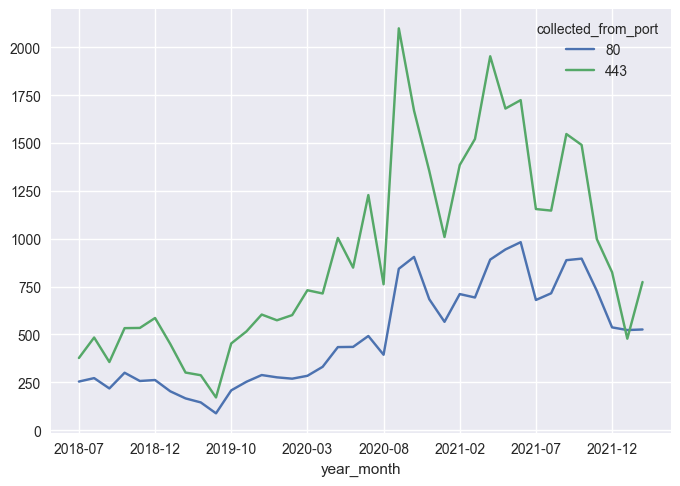

In [9]:
g.size().unstack().plot()

# Beacon metadata research

We first instantiate a `BeaconConfig` object from the `config_block` data and add this as new column called `bconfig`.
This allows us to extract additional Beacon information easier.

See also the documentation of `dissect.cobaltstrike`.

In [10]:
def beacon_config(row):
    bconfig = BeaconConfig(base64.b64decode(row.config_block))
    bconfig.xorkey = int(row.xorkey, 0)
    bconfig.xorencoded = row.xorencoded
    bconfig.pe_export_stamp = row.pe_export_stamp
    bconfig.pe_compile_stamp = row.pe_compile_stamp
    return bconfig

df["bconfig"] = df.progress_apply(beacon_config, axis=1)   

  0%|          | 0/128340 [00:00<?, ?it/s]

## Beacon version overviews

In [11]:
def aggregate_old_version(version):
    """This aggregates everything older than 4.0 as 3.x"""
    ver = beacon.BeaconVersion(version)
    if ver.tuple is None:
        print(version)
    if ver.tuple < (4, 0):
        return "Cobalt Strike 3.x"
    return ver.version_string
df["agg_version"] = df["beacon_version"].progress_apply(aggregate_old_version)
df["agg_version"]

  0%|          | 0/128340 [00:00<?, ?it/s]

0         Cobalt Strike 3.x
1         Cobalt Strike 3.x
2         Cobalt Strike 3.x
3         Cobalt Strike 3.x
4         Cobalt Strike 3.x
                ...        
128335    Cobalt Strike 4.5
128336    Cobalt Strike 4.4
128337    Cobalt Strike 4.5
128338    Cobalt Strike 4.3
128339    Cobalt Strike 4.0
Name: agg_version, Length: 128340, dtype: object

<AxesSubplot:xlabel='year_month'>

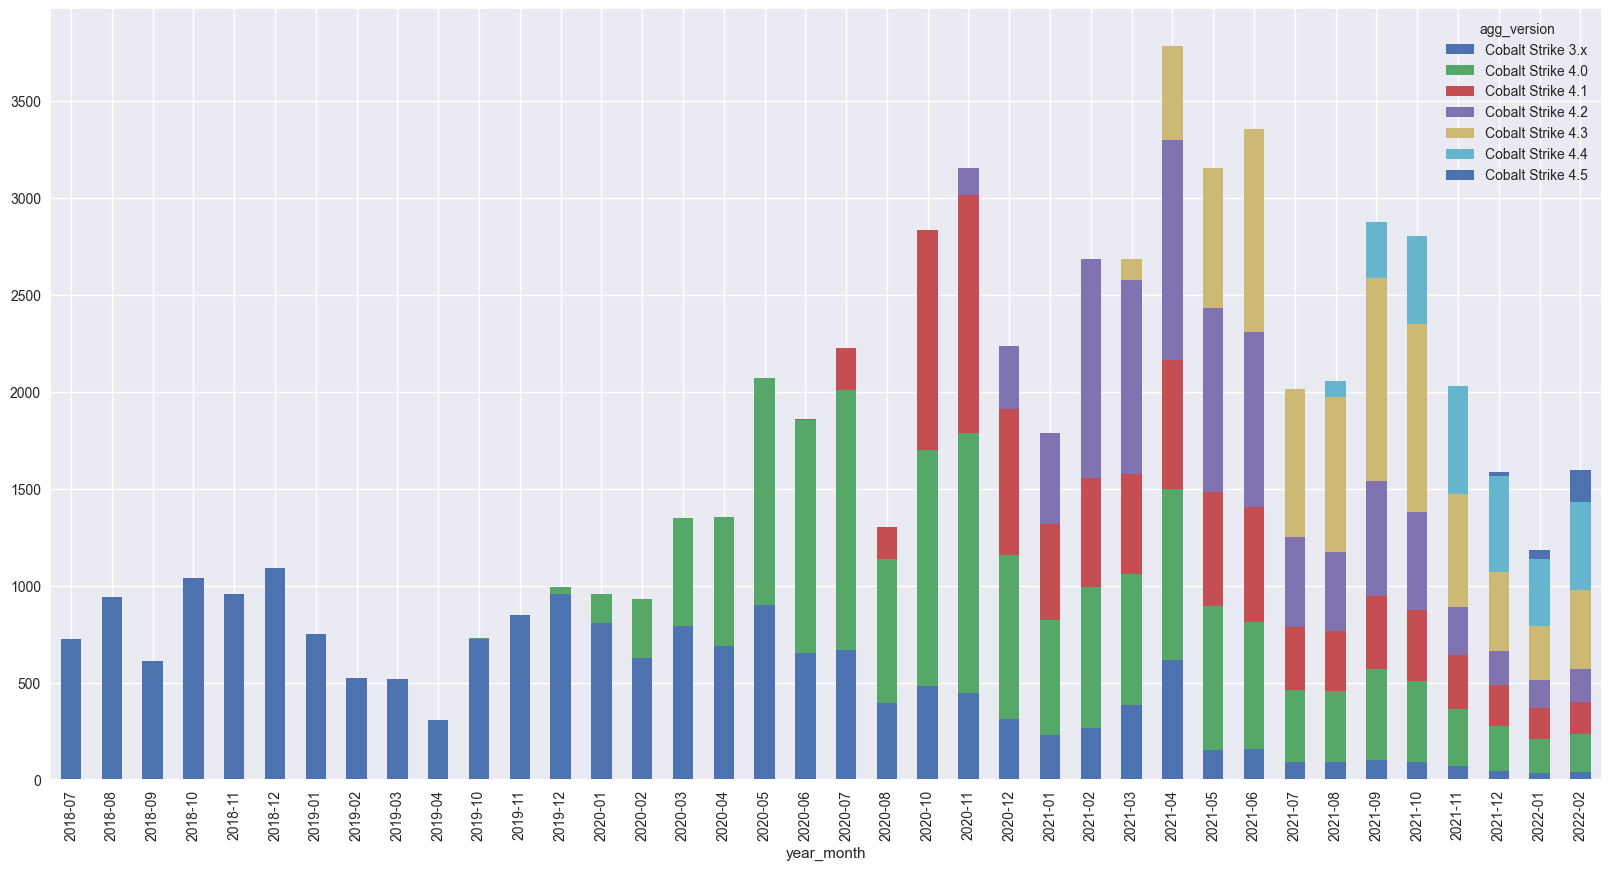

In [12]:
# this makes sure that a unique beacon is only counted once per year_month
df_year_month = df.drop_duplicates(['md5','collected_from_ip','collected_from_port','year_month'], keep='last')

versions = df_year_month.groupby(["year_month", "agg_version"]).size().unstack().fillna(0)
versions.plot.bar(stacked=True, figsize=(20, 10))
# print(versions.to_csv())

  0%|          | 0/128340 [00:00<?, ?it/s]

<AxesSubplot:xlabel='year_month'>

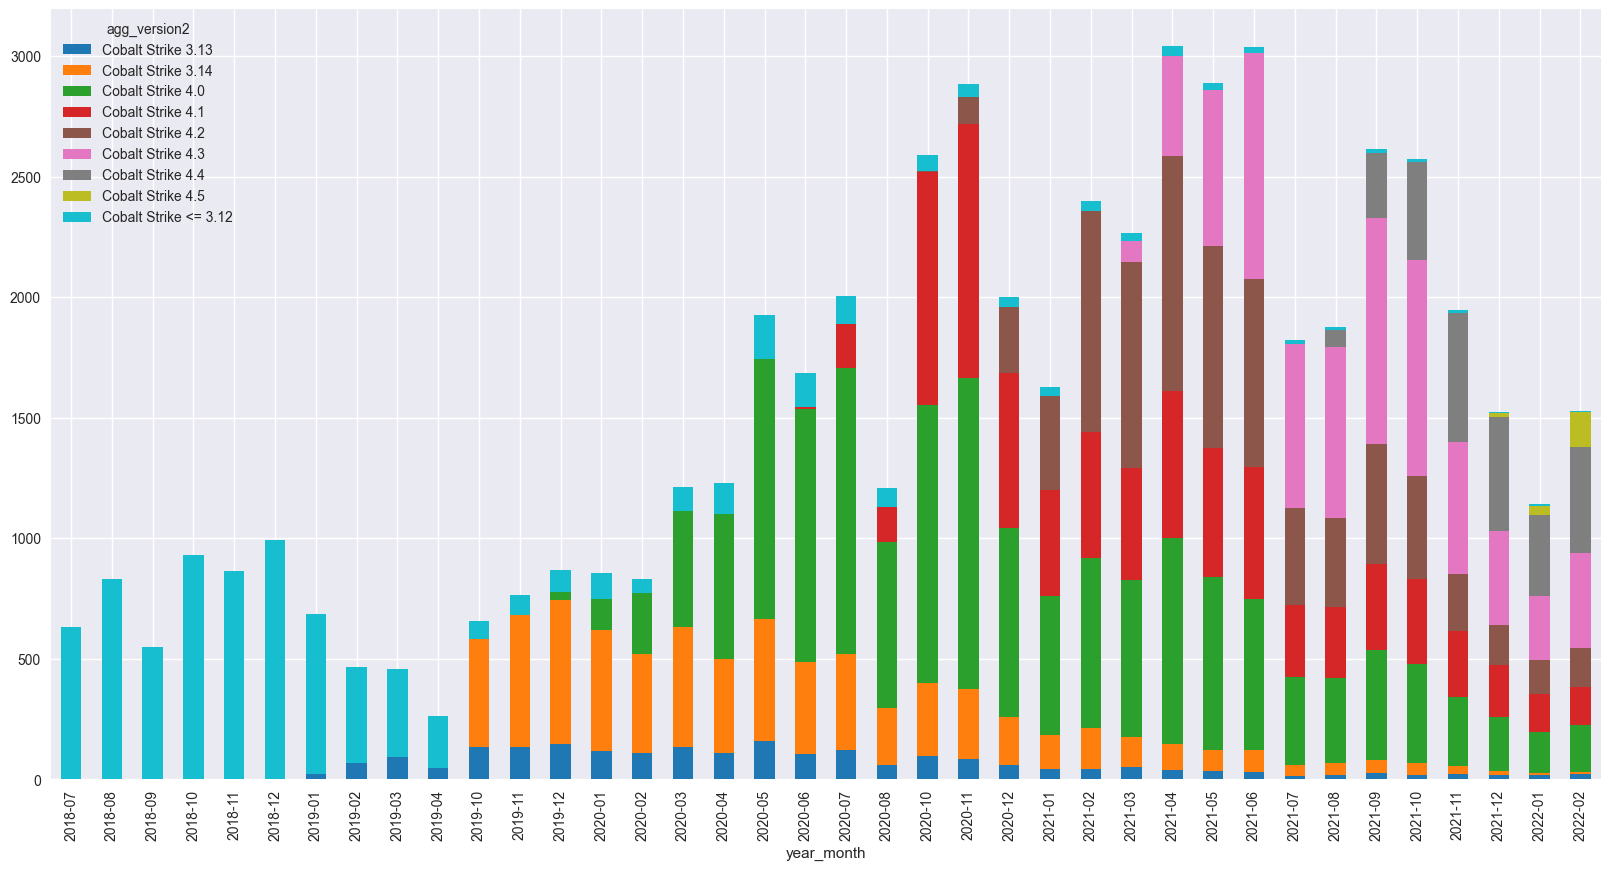

In [13]:
def aggregate_old_version2(version):
    version = beacon.BeaconVersion(version)
    if version.tuple <= (3, 12):
        return "Cobalt Strike <= 3.12"
    return version.version_string
df["agg_version2"] = df["beacon_version"].progress_apply(aggregate_old_version2)

# this makes sure that a unique beacon is only counted once per year_month
df_year_month = df.drop_duplicates(['md5','year_month'], keep='last')

versions = df_year_month.groupby(["year_month", "agg_version2"]).size().unstack().fillna(0)
versions.plot.bar(stacked=True, colormap='tab10', figsize=(20, 10))
# print(versions.to_csv())

In [14]:
df_year_month.groupby(["year_month", "agg_version2"]).size().unstack(fill_value="-")

agg_version2,Cobalt Strike 3.13,Cobalt Strike 3.14,Cobalt Strike 4.0,Cobalt Strike 4.1,Cobalt Strike 4.2,Cobalt Strike 4.3,Cobalt Strike 4.4,Cobalt Strike 4.5,Cobalt Strike <= 3.12
year_month,,,,,,,,,
2018-07,-,-,-,-,-,-,-,-,633
2018-08,-,-,-,-,-,-,-,-,830
2018-09,-,-,-,-,-,-,-,-,549
2018-10,-,-,-,-,-,-,-,-,933
2018-11,-,-,-,-,-,-,-,-,864
2018-12,-,-,-,-,-,-,-,-,995
2019-01,22,-,-,-,-,-,-,-,666
2019-02,68,-,-,-,-,-,-,-,398
2019-03,95,-,-,-,-,-,-,-,363


## Watermark Usage
Watermark, also known as customer or authorization id, should be unique. If they are re-used or have an "off" value, it can indicate a pirated version.

In [15]:
df_uniq_beacons = df.drop_duplicates(['md5'], keep='last')
# df_uniq_beacons.SETTING_WATERMARK = df_uniq_beacons.SETTING_WATERMARK.astype(pd.UInt32Dtype())
watermarks = df_uniq_beacons[["SETTING_WATERMARK", "SETTING_WATERMARK_HEX"]].value_counts().rename("count").reset_index()
watermarks["percent"] = (watermarks["count"] / watermarks["count"].sum() * 100).round(2).astype(str) + "%"
watermarks.head(20)
# print(watermarks.head(50).to_csv())

,SETTING_WATERMARK,SETTING_WATERMARK_HEX,count,percent
0,305419896,0x12345678,7931,23.49%
1,0,0x0,7727,22.88%
2,1359593325,0x5109bf6d,2362,6.99%
3,1873433027,0x6faa51c3,1492,4.42%
4,426352781,0x1969a08d,1448,4.29%
5,1234567890,0x499602d2,700,2.07%
6,1580103814,0x5e2e7886,694,2.06%
7,1,0x1,689,2.04%
8,1580103824,0x5e2e7890,674,2.0%
9,16777216,0x1000000,339,1.0%


## Public Key Usage
Public keys should be unique, as the private key is normally generated upon the first start of the Team Server. If they are re-used it can indicate a pirated version that is packaged with the public and private key pair. The public key can also be used for pivotting and correlation in the dataset.

In [16]:
df_uniq_beacons = df.drop_duplicates(['md5'], keep='last')
pubkey = df_uniq_beacons[["SETTING_PUBKEY_SHA256"]].value_counts().rename("count").reset_index()
pubkey["percent"] = (pubkey["count"] / pubkey["count"].sum() * 100).round(2).astype(str) + "%"
pubkey.head(20)

,SETTING_PUBKEY_SHA256,count,percent
0,36aff0b273cb7aa704e4219ad3be78defcc8c1d7ecb779...,3015,8.64%
1,c6df9424b64199e5a30097bb1324c89197e831703a8c7f...,1735,4.97%
2,c05695c59a64888a6c603a014ef89ed8f51bbdf3af7432...,509,1.46%
3,0d2c1591c8250291b1242214213004865099f401e20e7b...,401,1.15%
4,a593dd99a9d4845ce34857a365f79c2621d3738d55a21f...,347,0.99%
5,71fab2149cbdce552f00e6d75372494d3f7755d366fd68...,109,0.31%
6,afb21ece0b47440acc3ee710800b7741fd7d6b3b88efc1...,94,0.27%
7,0a66c65671962a56cffe273bbddad35e1f7c65cc97e62c...,91,0.26%
8,0ea137caee35d5f96a7b70647f63b58cd1a71829f46fd4...,85,0.24%
9,969a1320d8b2533247921024352fa0b684d6f326f9ad67...,77,0.22%


## Top XOR keys

The default XOR keys are `0x69` and `0x2e`. Other XOR keys inidicate modified Team Servers and beacons as this is not customizable by default.

In [17]:
df_uniq_beacons = df.drop_duplicates(['md5'], keep='last')
c = df_uniq_beacons["xorkey"].value_counts()
p = df_uniq_beacons["xorkey"].value_counts(normalize=True).mul(100).round(1)

cp = pd.concat([c, p], axis=1, keys=["seen", "percent"])
cp
# print(cp.to_csv())

,seen,percent
0x2e,26054,74.7
0x69,8631,24.7
0x3e,52,0.1
0x5a,45,0.1
0x3a,26,0.1
0xfc,11,0.0
0x2f,7,0.0
0x4d,7,0.0
0x8b,6,0.0
0x90,6,0.0


# Finding Malicious Beacons

Determine if a beacon payload is malicious using some indicators. It's by no means complete or fool proof; improvements are most welcome.

In [18]:
# Reused watermarks, we choose the top 20 of the most used watermarks
REUSED_WATERMARKS = list(watermarks["SETTING_WATERMARK"].head(20))

# Reused public keys, we choose the top 5 of the most reused pubkeys
REUSED_PUBKEYS = list(pubkey["SETTING_PUBKEY_SHA256"].head(5))

# Known good cobaltstrike.jar MD5's
KNOWN = [
    "303ae5ba3c016e498624505880fad314", # Cobalt Strike 4.0 (Dec 05, 2019) 
    "75612d550e900d0ae96c147dc931556f", # Cobalt Strike 4.0 (Feb 22, 2020) [bugfixes]
    "367635691cdd70722ef5706a8f0ca7e6", # Cobalt Strike 4.1 (Jun 25, 2020)
    "b54afe01ec6a75edf35e1a44f8bd3929", # Cobalt Strike 4.2 (Nov 06, 2020)
    "32cd41edf0810c5b5f498edf4731cc6d", # Cobalt Strike 4.3 (Mar 11, 2021)
    "b2736f1cbba90d42286fc42bfba74f4d", # Cobalt Strike 4.3 (Mar 17, 2021) [bugfixes]
    "222b8f27dbdfba8ddd559eeca27ea648", # Cobalt Strike 4.4 (Aug 04, 2021)
    "04e0a11be59147a8d73d2b3e9fea832c", # Cobalt Strike 4.5 (Dec 14, 2021)
]

def beacon_modifications(row):
    bconfig = row.bconfig

    # md5(cobaltstrike.jar)
    data = bconfig.raw_settings.get(BeaconSetting.SETTING_PROCINJ_STUB, "")
    jar_md5 = None
    if len(data) == 16:
        jar_md5 = data.hex()
    
    mods = []
    if bconfig.xorkey not in (0x2e, 0x69):
        # non default XOR keys indicate modification
        mods.append("modified_xorkey")
    if bconfig.xorencoded and bconfig.is_trial:        
        # xorencoded payloads are only available in the licensed versions
        mods.append("modified_trial")
    if bconfig.watermark is not None and bconfig.watermark < 1000:
        # low watermark number
        mods.append("bad_watermark")
    if bconfig.watermark in REUSED_WATERMARKS:
        # watermark in is in the top reused watermarks
        mods.append("reused_watermark")
    if row.SETTING_PUBKEY_SHA256 in REUSED_PUBKEYS:
        # public key is in the top reused pubkeys
        mods.append("reused_pubkey")
    if row.SETTING_WATERMARKHASH == "bnVsbA==":
        # looks like 4.5 is already leaked/pirated, the watermarkhash is set to b"null"
        mods.append("bad_watermarkhash")
    if jar_md5 and bconfig.version.tuple >= (3, 14) and jar_md5 not in KNOWN:
        # the MD5 of cobaltstrike.jar is not "official"
        mods.append("modified_jar")
    if mods:
        return "+".join(mods)
    return "normal"

df["modifications"] = df.progress_apply(beacon_modifications, axis=1)
df["is_modified"] = df["modifications"] != "normal"

  0%|          | 0/128340 [00:00<?, ?it/s]

In [19]:
df["modifications"].value_counts().reset_index()

,index,modifications
0,reused_watermark,40589
1,normal,40167
2,bad_watermark+reused_watermark,24913
3,reused_watermark+reused_pubkey,11775
4,bad_watermark+reused_watermark+reused_pubkey,5911
5,modified_trial,2390
6,modified_trial+bad_watermark+reused_watermark,1585
7,modified_xorkey+reused_watermark,289
8,modified_trial+reused_watermark,258
9,modified_xorkey+bad_watermark+reused_watermark,160


<AxesSubplot:title={'center':'modified vs normal'}, xlabel='year_month'>

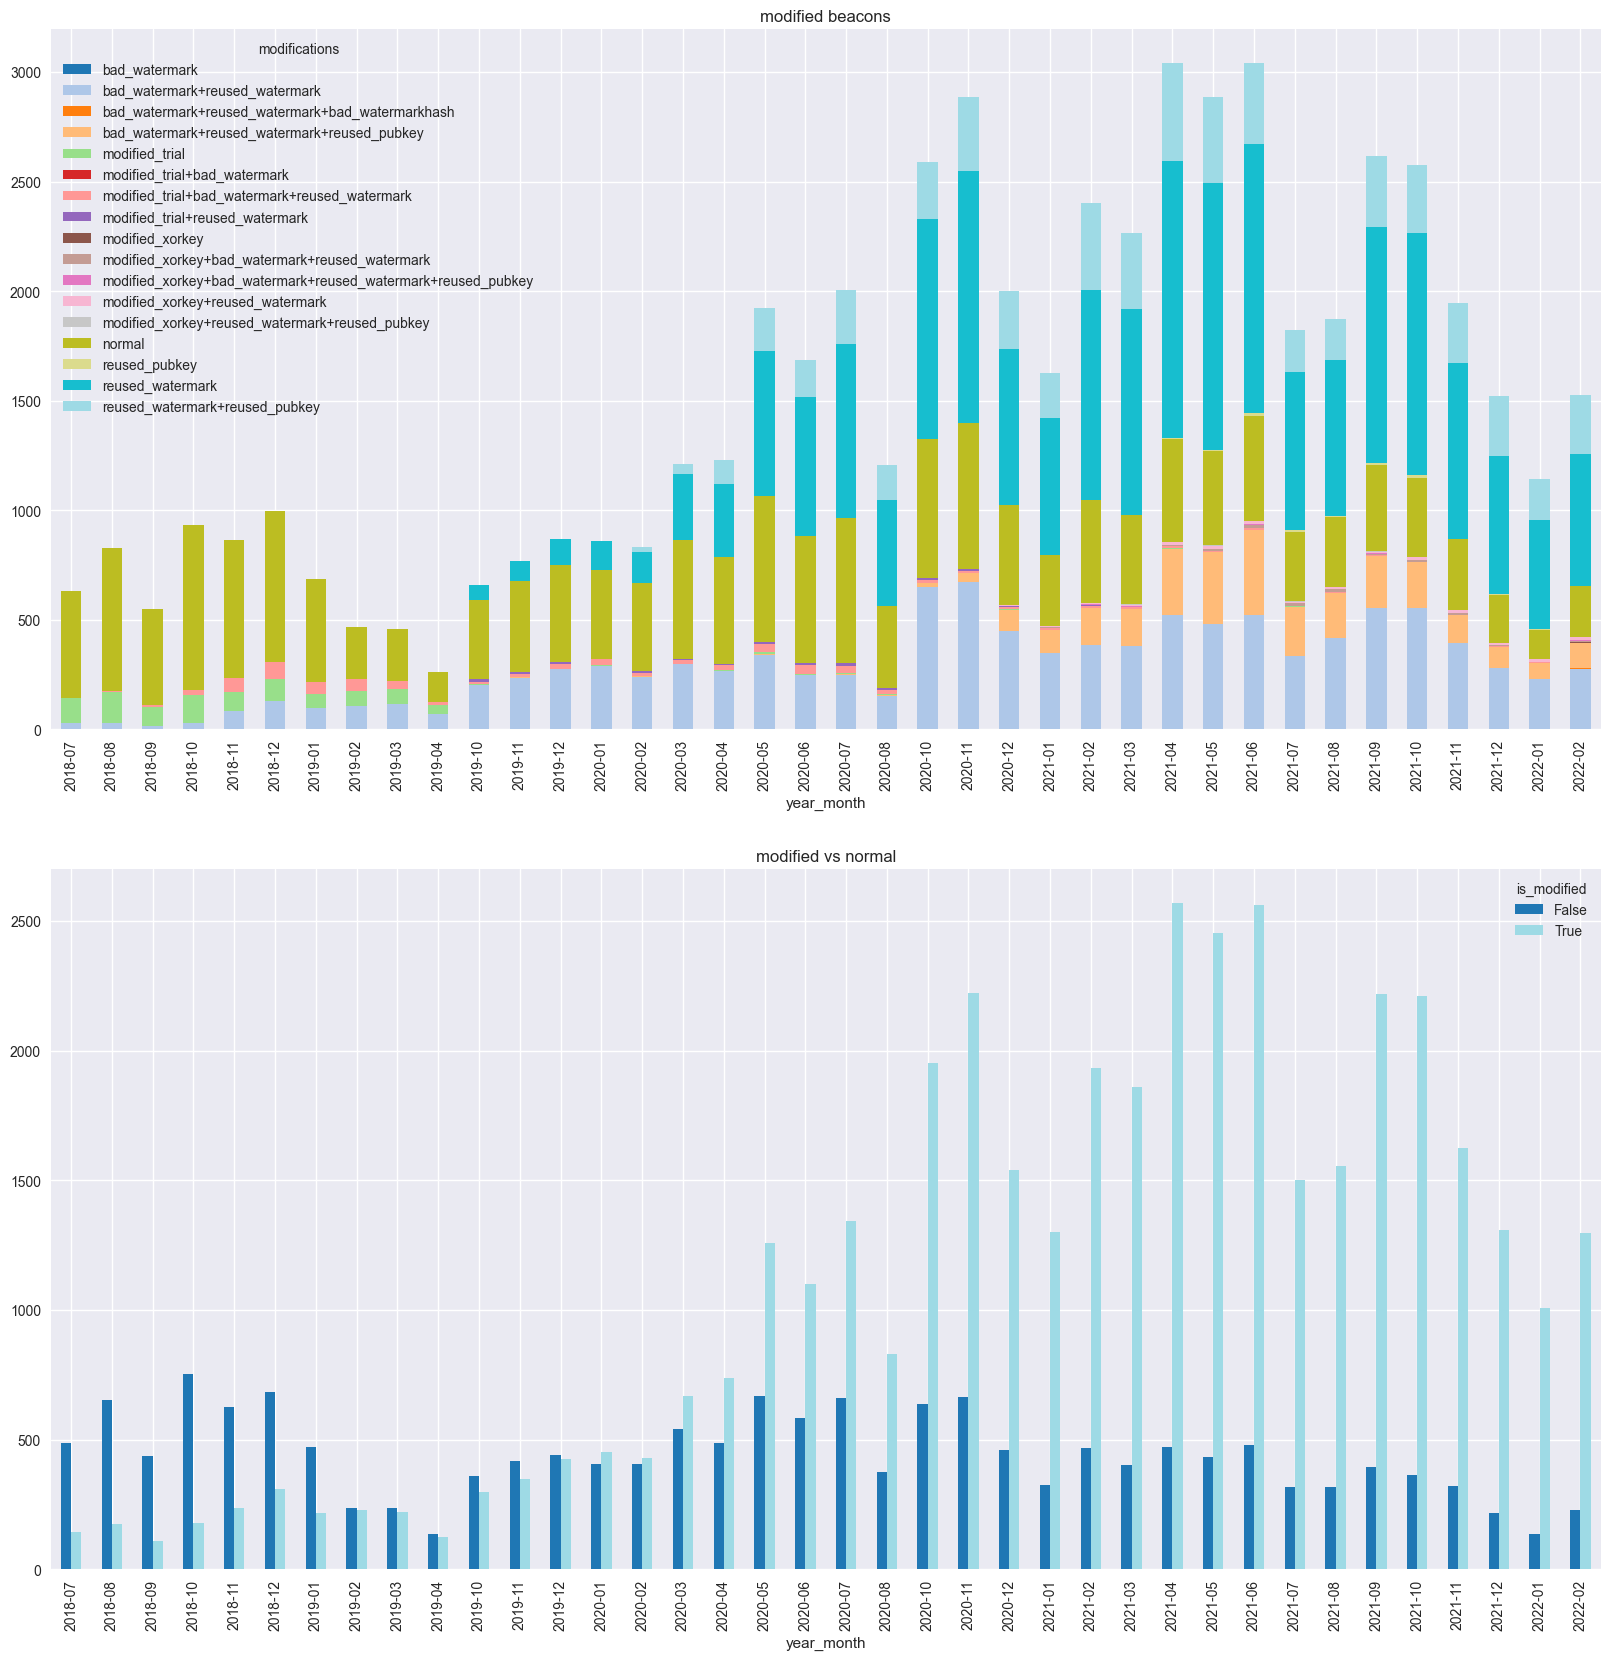

In [20]:
dd = df.drop_duplicates(['md5', 'year_month'], keep='last')
mods = dd.groupby(["year_month", "modifications"]).size().unstack().fillna(0)
is_mods = dd.groupby(["year_month", "is_modified"]).size().unstack().fillna(0)

fig, axs = plt.subplots(2, )
mods.plot.bar(stacked=True, colormap='tab20', ax=axs[0], figsize=(20, 20), title="modified beacons")
is_mods.plot.bar(colormap='tab20', ax=axs[1], figsize=(20, 20), title="modified vs normal")

## Malicious beacons per month

In [21]:
# Unique the beacons per month
dd = df.drop_duplicates(['md5', 'year_month'], keep='last')

# group by year_month and is_modified
mod_per_month = dd.groupby(["year_month", "is_modified"]).size().unstack()
mod_per_month = mod_per_month.reset_index().set_index("year_month")

# Add totals and percentages
mod_per_month["total"] = (mod_per_month[True] + mod_per_month[False])
mod_per_month["modified_p"] = (mod_per_month[True] / mod_per_month["total"] * 100).round(2).astype(str) + '%'
mod_per_month["normal_p"] = (mod_per_month[False] / mod_per_month["total"] * 100).round(2).astype(str) + '%'
mod_per_month
# mod_per_month.plot()

is_modified,False,True,total,modified_p,normal_p
year_month,,,,,
2018-07,489,144,633,22.75%,77.25%
2018-08,653,177,830,21.33%,78.67%
2018-09,438,111,549,20.22%,79.78%
2018-10,755,178,933,19.08%,80.92%
2018-11,628,236,864,27.31%,72.69%
2018-12,686,309,995,31.06%,68.94%
2019-01,472,216,688,31.4%,68.6%
2019-02,237,229,466,49.14%,50.86%
2019-03,237,221,458,48.25%,51.75%


## Find `first_modified` date

Now that we can identify if a beacon `is_modified` or not, we can determine when the first *modified* beacon appeared for a specific Cobalt Strike version.
The delta between `first_seen` and `first_modified` can indicate how long it took for a version to become leaked and pirated.

Note that we also do a check if `enum_version` is higher than `pe_version`, to find differences in the "beacon payload" and the "team server". A good example is `Cobalt Strike 4.5 (Dec 14, 2021)`, there are some beacons that have the `pe_export_stamp` of 4.4 but the enum version is 4.5. This indicates that a "cobaltstrike.jar" of version 4.5 is modified/cracked, but not properly as it uses encrypted resources (sleeves) from the previous 4.4 release. Most likely because they did not have the proper authorization (license) file to decrypt the sleeved resources, which includes the beacon.dll payload.

In [22]:
import collections
from dissect.cobaltstrike.version import BeaconVersion

MODIFIED_THRESHOLD = 2
normal_version_to_first_seen = collections.defaultdict(list)
modified_version_to_first_seen = collections.defaultdict(list)

# Map the first seen date for every beacon version (normal and modified)
for index, row in df.drop_duplicates(["md5"], keep="first").iterrows():
    bconfig = row["bconfig"]
    
    pe_version = BeaconVersion.from_pe_export_stamp(bconfig.pe_export_stamp)
    enum_version = BeaconVersion.from_max_setting_enum(bconfig.max_setting_enum)
    
    version = pe_version
    if enum_version.tuple and enum_version.tuple > pe_version.tuple:
        version = enum_version

    dt = row["collected_dt"]
    modified = row["modifications"] != "normal"

    if modified:
        modified_version_to_first_seen[version].append(dt)
    else:
        normal_version_to_first_seen[version].append(dt)

# Now check for a given day how many `modified` beacons we have, if this is more
# than MODIFIED_THRESHOLD, we note that day as the `first modified` date.
version_stats = []
for version, normal_dts in sorted(normal_version_to_first_seen.items(), key=lambda x: x[0].tuple):
    first_seen = min(normal_dts)
    day_to_dt = collections.defaultdict(list)
    modified_dts = modified_version_to_first_seen[version]
    for modified_dt in modified_version_to_first_seen[version]:
        day_key = modified_dt.strftime("%Y-%m-%d")
        day_to_dt[day_key].append(modified_dt)

    first_seen_modified = None
    for day, dts in sorted(day_to_dt.items()):
        # If we see modified amount > MODIFIED_THRESHOLD, we consider it
        # the first date we see in it `modified` in the wild.
        if len(dts) > MODIFIED_THRESHOLD:
            first_seen_modified = min(dts)
            break

    delta = None
    if first_seen_modified:
        delta = first_seen_modified - first_seen
    normal_count = len(normal_dts)
    modified_count = len(modified_dts)
    total_count = normal_count + modified_count
    version_stats.append([version, version.date, first_seen, first_seen_modified, delta, total_count, normal_count, modified_count])

In [23]:
# Create a new dataframe holding the delta and version statistics
version_df = pd.DataFrame(version_stats, columns=["version", "version_date", "first_seen", "first_modified", "delta", "total_count", "normal_count", "modified_count"])

# Add some percentages
version_df["modified_p"] = ((version_df["modified_count"] / version_df["total_count"]) * 100).round(2).astype(str) + "%"
version_df["normal_p"] = ((version_df["normal_count"] / version_df["total_count"]) * 100).round(2).astype(str) + "%"

# Only show versions > 4.0
version_df[version_df.version > "Cobalt Strike 4.0"].sort_values(["version_date"])

,version,version_date,first_seen,first_modified,delta,total_count,normal_count,modified_count,modified_p,normal_p
13,"Cobalt Strike 4.0 (Dec 05, 2019)",2019-12-05,2019-10-23,2020-02-12,112 days,9443,1319,8124,86.03%,13.97%
14,"Cobalt Strike 4.1 (Jun 25, 2020)",2020-06-25,2020-06-25,2020-07-28,33 days,5146,994,4152,80.68%,19.32%
15,"Cobalt Strike 4.2 (Nov 06, 2020)",2020-11-06,2020-10-25,2020-11-27,33 days,4876,739,4137,84.84%,15.16%
16,"Cobalt Strike 4.3 (Mar 03, 2021)",2021-03-03,2021-03-05,2021-04-02,28 days,4810,1081,3729,77.53%,22.47%
17,"Cobalt Strike 4.4 (Aug 04, 2021)",2021-08-04,2021-08-11,2021-08-24,13 days,1783,626,1157,64.89%,35.11%
18,"Cobalt Strike 4.5 (Dec 14, 2021)",2021-12-14,2021-12-20,2022-02-16,58 days,189,183,6,3.17%,96.83%


## Modified Beacon overview
Matrix with different modification counts

In [24]:
df.groupby(["year_month", "modifications"]).size().unstack().fillna(0).astype(int)
# df.groupby(["beacon_version", "modifications"]).size().unstack().fillna(0).astype(int)

modifications,bad_watermark,bad_watermark+reused_watermark,bad_watermark+reused_watermark+bad_watermarkhash,bad_watermark+reused_watermark+reused_pubkey,modified_trial,modified_trial+bad_watermark,modified_trial+bad_watermark+reused_watermark,modified_trial+reused_watermark,modified_xorkey,modified_xorkey+bad_watermark+reused_watermark,modified_xorkey+bad_watermark+reused_watermark+reused_pubkey,modified_xorkey+reused_watermark,modified_xorkey+reused_watermark+reused_pubkey,normal,reused_pubkey,reused_watermark,reused_watermark+reused_pubkey
year_month,,,,,,,,,,,,,,,,,
2018-07,0,42,0,0,281,0,0,0,0,0,0,0,0,1147,0,0,0
2018-08,0,58,0,0,308,0,15,0,0,0,0,0,0,1382,0,0,0
2018-09,0,18,0,0,101,0,7,0,0,0,0,0,0,485,0,0,0
2018-10,0,54,0,0,282,0,35,0,0,0,0,0,0,1535,0,0,0
2018-11,0,168,0,0,231,0,136,0,0,0,0,0,0,1524,0,0,0
2018-12,0,268,0,0,296,3,204,0,0,0,0,0,0,1934,0,0,0
2019-01,0,256,0,0,208,3,149,0,0,0,0,0,0,1362,0,0,0
2019-02,0,182,0,0,218,2,98,0,0,0,0,0,0,551,0,0,0
2019-03,0,168,0,0,252,1,60,0,0,0,0,0,0,551,0,0,0


# PE artifacts statistics

Overview of some extracted PE artifacts from the beacon payloads.

In [25]:
def b64decode(stage):
    return base64.b64decode(stage) if stage else stage

# We need to base64 decode the data first
df["stage_prepend_decoded"] = df["stage_prepend"].progress_apply(b64decode)
df["stage_append_decoded"] = df["stage_append"].progress_apply(b64decode)
df["magic_pe_decoded"] = df["magic_pe"].progress_apply(b64decode)
df["magic_mz_decoded"] = df["magic_mz"].progress_apply(b64decode)

  0%|          | 0/128340 [00:00<?, ?it/s]

  0%|          | 0/128340 [00:00<?, ?it/s]

  0%|          | 0/128340 [00:00<?, ?it/s]

  0%|          | 0/128340 [00:00<?, ?it/s]

## MZ header

In [26]:
def is_ascii(data):
    return data.isascii() if data else False

df["stage_prepend_is_ascii"] = df["stage_prepend_decoded"].progress_apply(is_ascii)
df["magic_mz_is_ascii"] = df["magic_mz_decoded"].progress_apply(is_ascii)
df["magic_pe_is_ascii"] = df["magic_pe_decoded"].progress_apply(is_ascii)

df[df["magic_mz_is_ascii"]].drop_duplicates(["md5"])["magic_mz_decoded"].value_counts().reset_index()
# print(df[df["magic_mz_is_ascii"]].drop_duplicates(["md5"])["magic_mz_decoded"].value_counts().to_csv())


  0%|          | 0/128340 [00:00<?, ?it/s]

  0%|          | 0/128340 [00:00<?, ?it/s]

  0%|          | 0/128340 [00:00<?, ?it/s]

,index,magic_mz_decoded
0,b'MZ',23192
1,b'MZRE',11442
2,b'MZREMZRE',62
3,b'H@KC',25
4,b'@H@H',17
5,b']U]U',13
6,b'TG',12
7,b'MSBE',10
8,b'KCKC',7
9,b'MEME',7


## PE header

In [27]:
df[df["magic_pe_is_ascii"]].drop_duplicates(["md5"])["magic_pe_decoded"].value_counts().reset_index().head(20)

,index,magic_pe_decoded
0,b'PE',33517
1,b'NO',959
2,b'EA',123
3,b'CE',11
4,b'AS',11
5,b'SB',10
6,b'MO',8
7,b'SO',6
8,b'ZE',6
9,b'VF',6


## Stage prepend

Should be valid shellcode as this is prepended in front of the reflective beacon payload.

In [28]:
prepend_ascii_df = df[df["stage_prepend_is_ascii"]].drop_duplicates(["md5"])["stage_prepend_decoded"].value_counts()
prepend_ascii_df.reset_index()
# print(prepend_ascii_df.to_csv())

,index,stage_prepend_decoded
0,b'$$$$$',10
1,b'@H@H@H@H',8
2,b'AAAAAA',6
3,b'GOEMGODL',6
4,b'ZRZR',5
5,b'AA',4
6,b'PPP',4
7,b'GCGBOKJO',3
8,b'CKCKRZCKAICKAI',2
9,b'BBBBBB',2


## Stage append
This is data appended to the beacon payload, it does not have to be valid shellcode. The *EICAR* string is inserted automatically for trial versions of Cobalt Strike.

In [29]:
df[df["stage_append_decoded"].notna()]["stage_append_decoded"].value_counts().reset_index()

,index,stage_append_decoded
0,,32162
1,b'X5O!P%@AP[4\\PZX54(P^)7CC)7}$EICAR-STANDARD-...,1098
2,b'\x90\xd9\xfa\x90\xd9\xff',361
3,b'\x90\x90\x90',250
4,b'\x90\x90',230
5,b'\x90\x90\x90\x90\x90\x90\x90\x90\x90\x90\x90...,86
6,b'\x90P\x90P',73
7,b'x90\x90\x90\x90\x90\x90\x90',62
8,b'\x89\xec]\xc3',40
9,b'www',38


# Export IOCs to CSV

Export ip and host indicators to a CSV for easy grep and processing.

In [30]:
import binascii

In [31]:
def hosts_for_bconfig(bconfig):
    """Return both the configured domains and 'Host:' headers"""
    host_headers = []
    for setting in ["SETTING_C2_REQUEST", "SETTING_C2_POSTREQ"]:
        for (key, val) in bconfig.settings.get(setting, []):
            if key in ("_HEADER", "_HOSTHEADER"):
                header, _, value = val.partition(b":")
                if header.lower() == b"host":
                    host_headers.append(value.strip().decode())
    return set(bconfig.domains), set(host_headers)

rows = []
for index, row in df.iterrows():
    bconfig = row["bconfig"]
    domains, hostheaders = hosts_for_bconfig(bconfig)
    data = [
        row.collected_from_ip,
        row.collected_from_port,
        bconfig.protocol,
        bconfig.version,
        bconfig.xorkey,
        ", ".join(sorted(domains)),
        ", ".join(sorted(hostheaders)),
        row.collected_dt,
        row.country,
        row.asn,
        row.org,
        bconfig.settings.get("SETTING_USERAGENT", ""),
        bconfig.settings.get("SETTING_SPAWNTO_X86", ""),
        bconfig.settings.get("SETTING_SPAWNTO_X64", ""),
        ', '.join(bconfig.settings.get("SETTING_PROCINJ_EXECUTE", "")),
        bconfig.settings.get("SETTING_SUBMITURI", ""),
        hex( bconfig.settings.get("SETTING_WATERMARK", 0) )

    ]

    rows.append(data)

In [32]:
print(hex(bconfig.settings.get("SETTING_WATERMARK")))
# procura se existe o valor na coluna, coloca vazio, encoda para bytes, converte para hex, decode de bytes para string
print( binascii.hexlify(str(1359593325).encode()).decode("utf-8"))
print( hex(1359593325) )
# 
hex(0)

0x12345678
31333539353933333235
0x5109bf6d


'0x0'

In [33]:
export_df = pd.DataFrame(rows, columns=["ip", "port", "protocol", "version", "xorkey", "domains", "host_header", "collected_dt", "country", "asn", "org", "user_agent", "spawnto_x86", "spawnto_x64", "procinj_execute", "submituri", "watermark_hex"])
export_df["asn"] = export_df["asn"].astype(pd.UInt32Dtype())
export_df = export_df.sort_values(["collected_dt", "ip", "port", "protocol", "version", "xorkey", "domains", "host_header"]).reset_index()

In [34]:
export_df = export_df.groupby(["ip", "port", "protocol", "version", "xorkey", "domains", "host_header","country", "asn", "org", "user_agent", "spawnto_x86", "spawnto_x64", "procinj_execute", "submituri", "watermark_hex"])["collected_dt"].agg(["first", "last"]).sort_values(["first"])
export_df["delta_days"] = (export_df["last"] - export_df["first"]).dt.days
export_df = export_df.rename(columns={"first": "first_seen", "last": "last_seen"})
export_df = export_df.reset_index()[["ip", "port", "protocol", "version",  "xorkey", "domains", "host_header", "first_seen", "last_seen", "delta_days", "country", "asn", "org", "user_agent", "spawnto_x86", "spawnto_x64", "procinj_execute", "submituri", "watermark_hex"]]

In [35]:
export_df["country"].value_counts()

United States    10809
China             6441
Hong Kong         2665
Netherlands       2146
Germany           1563
                 ...  
Uzbekistan           1
Iran                 1
Argentina            1
Kyrgyzstan           1
Tunisia              1
Name: country, Length: 82, dtype: int64

In [36]:
#import requests
# pip install requests
#def get_country_ip(ip):
#    url = 'https://get.geojs.io/v1/ip/geo/{ip}.json'.format(ip=ip)
#    response = requests.get(url)
#    try:
#        return response.json()['country']
#    except Exception as e:
#        print("Error: ",e)
#        return ""

In [37]:
print(row["bconfig"].settings["SETTING_SPAWNTO_X86"])
print(row["bconfig"].settings["SETTING_SPAWNTO_X64"])
print(row["bconfig"].settings["SETTING_USERAGENT"])
print(row["bconfig"].settings["SETTING_PROCINJ_EXECUTE"])
print(row["bconfig"].settings["SETTING_PROCINJ_ALLOCATOR"])
print(row["bconfig"].settings["SETTING_SUBMITURI"]) 
print(row["bconfig"].architecture)
print(row["bconfig"].settings["SETTING_WATERMARK"])

hex(bconfig.watermark)

#print(row["bconfig"])

#from pprint import pprint
#pprint(vars(bconfig))
#dir(bconfig)

import binascii
x=b'test'
x=binascii.hexlify(x)
# x
# b'74657374'
y=str(x,'ascii')
# y
# '74657374'
x=binascii.unhexlify(x)
# x
# b'test'
y=str(x,'ascii')
# y
# 'test'


%windir%\syswow64\rundll32.exe
%windir%\sysnative\rundll32.exe
Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; BOIE9;SVSE)
['CreateThread', 'SetThreadContext', 'CreateRemoteThread', 'RtlCreateUserThread']
0
/submit.php
None
305419896


In [38]:
export_df.head()

,ip,port,protocol,version,xorkey,domains,host_header,first_seen,last_seen,delta_days,country,asn,org,user_agent,spawnto_x86,spawnto_x64,procinj_execute,submituri,watermark_hex
0,176.122.175.66,80,http,"Cobalt Strike 3.8 (May 23, 2017)",105,"down.pumalinexplorer.com, mail.pumalinexplorer...",mail.google.com,2018-07-04,2018-10-01,89,United States,25820,IT7NET,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,%windir%\syswow64\rundll32.exe,%windir%\sysnative\rundll32.exe,,/mail/u/0/,0x0
1,54.183.120.61,443,https,"Cobalt Strike 3.10 (Dec 11, 2017)",105,images.level8metrics.com,,2018-07-04,2018-07-23,19,United States,16509,AMAZON-02,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,%windir%\syswow64\rundll32.exe,%windir%\sysnative\rundll32.exe,,/dE,0x2af8a718
2,185.183.98.244,443,https,"Cobalt Strike 3.11 (May 24, 2018)",105,185.183.98.226,,2018-07-04,2018-07-13,9,Netherlands,60117,Host Sailor Ltd,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,%windir%\syswow64\rundll32.exe,%windir%\sysnative\rundll32.exe,,/submit.php,0x3333c584
3,51.38.187.74,443,https,"Cobalt Strike 3.8 (May 23, 2017)",105,51.38.187.74,,2018-07-04,2018-07-04,0,France,16276,OVH SAS,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,%windir%\syswow64\rundll32.exe,%windir%\sysnative\rundll32.exe,,/submit.php,0x0
4,185.183.98.226,443,https,"Cobalt Strike 3.11 (May 24, 2018)",105,185.183.98.226,,2018-07-04,2018-07-04,0,Netherlands,60117,Host Sailor Ltd,Mozilla/4.0 (compatible; MSIE 7.0; Windows NT ...,%windir%\syswow64\rundll32.exe,%windir%\sysnative\rundll32.exe,,/submit.php,0x3333c584


In [39]:
open("iocs-export.csv", "w").write(export_df.to_csv())

13454933

In [40]:
export_df.to_csv("iocs-export_sem_index.csv",index=False)